In [2]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import median, stdev

In [3]:

def ratios_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [4]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

In [23]:
score_dir = "/home/wanxinli/EHR-OT/outputs/mimic/"

group_name = 'insurance'
group_1 = 'Medicaid'
group_2 = 'Self_Pay'

# group_name = 'gender'
# group_1 = 'M'
# group_2 = 'F'

# group_name = 'ethnicity'
# group_1 = 'WHITE'
# # group_2 = 'HISPANIC_OR_LATINO'
# group_2 = 'ASIAN'

trans_metrics = ['GWOT', 'OT', 'TCA', 'NN', 'CA', 'GFK']


MAE for GWOT, Median: 21.4%, Stdev: 8.8%
MAE for OT, Median: 20.9%, Stdev: 8.9%
MAE for TCA, Median: 0.4%, Stdev: 1.2%
MAE for NN, Median: 18.3%, Stdev: 8.5%
MAE for CA, Median: -2.7%, Stdev: 8.5%
MAE for GFK, Median: -26.0%, Stdev: 13.7%


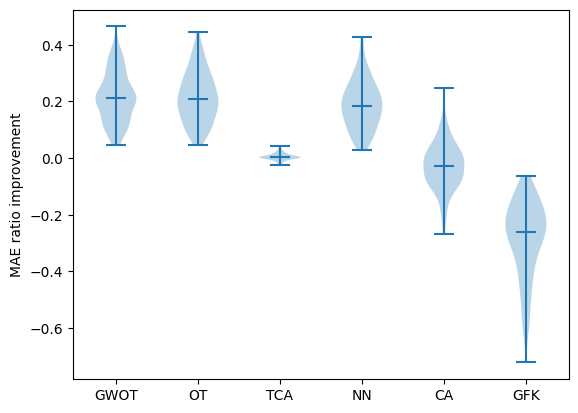

In [24]:
mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'mae', trans_metrics)
print_median_std(mae_improve_ratios, trans_metrics, 'MAE')

# Pandas dataframe

trans_metric_dict = {}
for i in range(len(trans_metrics)):
    trans_metric_dict[trans_metrics[i]] = mae_improve_ratios[i]
data = pd.DataFrame(trans_metric_dict)

# Plot the dataframe
plt.violinplot(data, showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel("MAE ratio improvement")
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_MAE.pdf")
plt.savefig(fig_path)
plt.show()


RMSE for GWOT, Median: 8.8%, Stdev: 7.2%
RMSE for OT, Median: 8.4%, Stdev: 7.2%
RMSE for TCA, Median: -0.1%, Stdev: 0.8%
RMSE for NN, Median: 5.7%, Stdev: 6.4%
RMSE for CA, Median: -1.3%, Stdev: 7.6%
RMSE for GFK, Median: -10.2%, Stdev: 8.7%


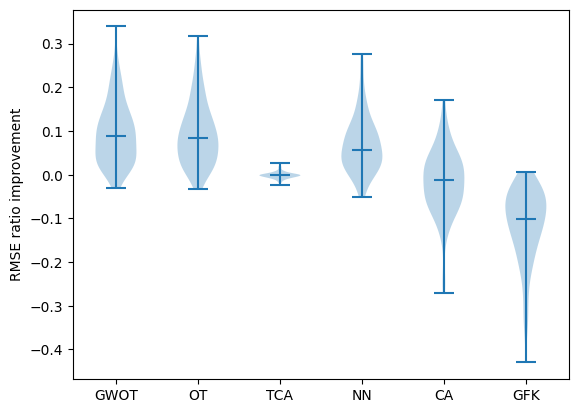

In [25]:
mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'rmse', trans_metrics)
print_median_std(mae_improve_ratios, trans_metrics, 'RMSE')

# Pandas dataframe

trans_metric_dict = {}
for i in range(len(trans_metrics)):
    trans_metric_dict[trans_metrics[i]] = mae_improve_ratios[i]
data = pd.DataFrame(trans_metric_dict)

# Plot the dataframe
plt.violinplot(data, showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel("RMSE ratio improvement")
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_RMSE.pdf")
plt.savefig(fig_path)
plt.show()



In [6]:
def print_latex(ratios):
    """ 
    Print latex for ratios
    """
    print_str = ""
    for ratio in ratios:
        print_str += f' & {median(ratio)*100:.1f}({stdev(ratio)*100:.1f})'
    print(print_str)
    

In [9]:
group_name = 'insurance'
groups = ['Self_Pay', 'Government', 'Private',  'Medicare', 'Medicaid']

# trans_metrics = ['GWOT']
trans_metrics = ['GWOT', 'OT', 'TCA', 'NN', 'CA', 'GFK']
eval_metric = 'rmse'

# group_name = 'marital_status'
# groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        print(f"group 1: {group_1}, group_2: {group_2}")
        # mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'mae', trans_metrics)
        # print_median_std(mae_improve_ratios, trans_metrics, 'MAE')
        rmse_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        print(rmse_improve_ratios)
        print_median_std(rmse_improve_ratios, trans_metrics, eval_metric)
        print_latex(rmse_improve_ratios)

group 1: Government, group_2: Self_Pay
[[-0.030018845490030668, 0.11108183637113624, 0.10973239602777073, 0.11708310147315376, 0.1625011979653508, 0.03992235054051995, 0.0554784627991228, 0.08431429685667949, 0.07190061792767868, 0.23264678644290074, 0.06539049665619052, 0.09422504894573819, 0.0935009236131003, 0.04611141064196456, 0.11625625737051679, 0.1759860450452182, -0.021150394421011423, 0.13743172298255218, 0.11708442590749357, 0.2878623338042476, 0.09170565089080022, 0.19361538031097056, 0.18160361592450736, 0.1284542502453389, 0.029863917842828932, 0.06607859518559452, 0.12920657741189565, 0.08355969502347883, 0.10742467937499359, 0.20440444296309804, 0.3854034013142374, 0.18516874201293193, 0.10227462130675596, 0.07678578232650858, 0.16437041744632472, 0.2038664620885061, 0.29382825408719265, 0.08569354820722352, -0.002219148315215406, 0.11160852261994984, 0.04114187139876274, 0.07653379673890338, 0.07797743069566918, 0.09811037201363232, 0.029023997191503798, 0.159772383923